# CS294-112 Deep Reinforcement Learning HW1 Q4 DAgger

Yifat Amir

### Libraries

In [9]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import sklearn.utils as sku
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Implementation

In [10]:
def get_train_test_splits(obs_file, act_file, train_amount = None):
    print('loading expert observations and actions data')

    obs = np.load(obs_file).astype(np.float32)
    scaler = StandardScaler().fit(obs)
    obs = scaler.transform(obs).astype(np.float32)
    
    act = np.squeeze(np.load(act_file).astype(np.float32))
    
    if train_amount == None:
        return obs, None, act, None, scaler
    n_samples = obs.shape[0]
    obs_train, obs_test = train_test_split(obs, train_size = train_amount)
    act_train, act_test = train_test_split(act, train_size = train_amount)
    return obs_train, obs_test, act_train, act_test, scaler

def train(obs_train, act_train):
    sess = tf.InteractiveSession()
    
    y_ = tf.placeholder(tf.float32, shape=[None, num_act_features])
    x = tf.placeholder(tf.float32, shape=[None, num_obs_features])
    layer1 = tf.contrib.layers.fully_connected(x, num_obs_features, activation_fn = tf.nn.tanh, weights_initializer=tf.contrib.layers.xavier_initializer())
    layer2 = tf.contrib.layers.fully_connected(layer1, num_obs_features, activation_fn = tf.nn.tanh, weights_initializer=tf.contrib.layers.xavier_initializer())
    y = tf.contrib.layers.fully_connected(layer2, num_act_features, activation_fn = None, weights_initializer=tf.contrib.layers.xavier_initializer())
    
    policy_fn = tf_util.function([x], y)

    loss = tf.nn.l2_loss(y_ - y) / batch_size

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    tf.global_variables_initializer().run()
    losses = []
    for i in range(num_iters):
        x_batch, y_batch = sku.shuffle(obs_train, act_train, n_samples = batch_size)
        a, loss_now = sess.run(fetches=[train_step, loss], feed_dict={x: x_batch, y_: y_batch})
        if (i % (num_iters/5) == 0):
            print "training iter #", i
            losses.append(loss_now)

    return policy_fn

def rollout(policy_fn):
    env = gym.make(creature + "-v1")
    max_steps = env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(10):
    #     print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = policy_fn(scaler.transform(obs[None,:]).astype('float32'))
            observations.append(scaler.transform(obs.reshape(1, -1)).astype('float32'))
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
    #         env.render()
    #         if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)

    my_data = {'observations': np.array(observations),
                   'actions': np.array(actions)}
    return my_data, returns, np.mean(returns), np.std(returns)

def get_new_actions(new_observations, expert_policy_file):
    new_actions = np.empty((0, num_act_features))
    expert_policy_fn = load_policy.load_policy(expert_policy_file)
    tf_util.initialize()
    for obser in new_observations:
        action = expert_policy_fn(obser)
        new_actions = np.append(new_actions, action, axis = 0)
    return new_actions

### Hyperparameters

In [11]:
obs_file, act_file = ("obs_Walker2d-v1115109102017.npy", "act_Walker2d-v1115109102017.npy")
# ("obs_Hopper-v1044909042017.npy", "act_Hopper-v1044909042017.npy")
# ("obs_Humanoid-v1044209042017.npy", "act_Humanoid-v1044209042017.npy")
# ("obs_Ant-v1112809102017.npy", "act_Ant-v1112809102017.npy")
# ("obs_Reacher-v1113609102017.npy", "act_Reacher-v1113609102017.npy")
# ("obs_HalfCheetah-v1114209102017.npy", "act_HalfCheetah-v1114209102017.npy")
# ("obs_Walker2d-v1115109102017.npy", "act_Walker2d-v1115109102017.npy")
creature = "Walker2d"
expert_policy_file = "experts/" + creature + "-v1.pkl"
num_iters = 20000
num_dagger_iters = 4
batch_size = 100
learning_rate = 0.001

### Load the Data

In [12]:
obs_train, obs_test, act_train, act_test, scaler = get_train_test_splits(obs_file, act_file)
print obs_train.shape
print act_train.shape
num_obs_features = obs_train.shape[1]
num_act_features = act_train.shape[1]

loading expert observations and actions data
(20000, 17)
(20000, 6)


### DAgger Algorithm

In [13]:
def dagger(obs_train, act_train, expert_policy_file, num_dagger_iters):
    mean_rs = []
    sd_rs = []
    for i in range(num_dagger_iters):
        print obs_train.shape
        print "Dagger iter:", i
        # behavioral clone (train)
        policy_fn = train(obs_train, act_train)
        # run rollouts of your policy to get more observations
        my_data, returns, mean_return, sd_return = rollout(policy_fn)
        mean_rs.append(mean_return)
        sd_rs.append(sd_return)
        new_observations = my_data['observations']
        # call expert policy on those observations to get actions
        new_actions = get_new_actions(new_observations, expert_policy_file)
        # aggregate the found observations and actions into the training set
        obs_train = np.concatenate([obs_train, np.squeeze(new_observations)])
        act_train = np.concatenate([act_train, new_actions])
        # repeat!
    return mean_rs, sd_rs

In [14]:
means, sds = dagger(obs_train, act_train, expert_policy_file, num_dagger_iters)

(20000, 17)
Dagger iter: 0
training iter # 0
training iter # 4000
training iter # 8000
training iter # 12000
training iter # 16000


[2017-09-13 18:53:48,336] Making new env: Walker2d-v1


('obs', (1, 17), (1, 17))
Instructions for updating:
Please use tf.global_variables instead.


[2017-09-13 18:54:00,654] From tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-09-13 18:54:00,705] From /Users/patrickohalloran/Desktop/yifat/deep_rl/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:175: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


(30000, 17)
Dagger iter: 1
training iter # 0
training iter # 4000
training iter # 8000
training iter # 12000
training iter # 16000


[2017-09-13 18:54:41,120] Making new env: Walker2d-v1


('obs', (1, 17), (1, 17))
Instructions for updating:
Please use tf.global_variables instead.


[2017-09-13 18:54:42,890] From tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-09-13 18:54:42,941] From /Users/patrickohalloran/Desktop/yifat/deep_rl/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:175: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


(31634, 17)
Dagger iter: 2
training iter # 0
training iter # 4000
training iter # 8000
training iter # 12000
training iter # 16000


[2017-09-13 18:55:20,597] Making new env: Walker2d-v1


('obs', (1, 17), (1, 17))
Instructions for updating:
Please use tf.global_variables instead.


[2017-09-13 18:55:21,175] From tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-09-13 18:55:21,232] From /Users/patrickohalloran/Desktop/yifat/deep_rl/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:175: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


(32108, 17)
Dagger iter: 3
training iter # 0
training iter # 4000
training iter # 8000
training iter # 12000
training iter # 16000


[2017-09-13 18:55:59,917] Making new env: Walker2d-v1


('obs', (1, 17), (1, 17))
Instructions for updating:
Please use tf.global_variables instead.


[2017-09-13 18:56:00,321] From tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-09-13 18:56:00,373] From /Users/patrickohalloran/Desktop/yifat/deep_rl/lib/python2.7/site-packages/tensorflow/python/util/tf_should_use.py:175: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


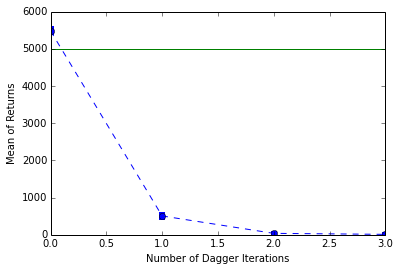

In [15]:
plt.errorbar(list(range(len(means))), means, yerr = sds, fmt='--o', capthick=4)
plt.plot(list(range(len(means))), [4995.4266902009167 for i in range(len(means))])
plt.ylabel('Mean of Returns')
plt.xlabel('Number of Dagger Iterations')
plt.show()

In [8]:
print creature

Walker2d


The task above was run on a NN with two hidden layers, tanh activation, 20000 sample points, 10000 training iterations, batch size of 100, and learning rate of 0.001. There were 4 DAgger iterations.